# Final Test — SUS Analysis by Prototype

This notebook analyzes System Usability Scale (SUS) scores for the final test. It:
- Uses survey responses in this folder.
- Filters to participants tied to submission IDs 57–74, excluding 60.
- Computes SUS per prototype (A = Baseline, B = Post-Capture, C = Real-Time).
- Summarizes and visualizes SUS scores.

Reference: How to use the System Usability Scale (SUS): https://usabilitygeek.com/how-to-use-the-system-usability-scale-sus-to-evaluate-the-usability-of-your-website/

In [1]:
# Imports and display settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print('Libraries ready')

Libraries ready


## Load Data and Filter Participants
Link survey respondents to database submissions via the entered username. Keep only respondents whose usernames match submissions with IDs in [57..74], excluding 60.

## Research Hypothesis

**Primary Hypothesis (Directional):**
$$H_A: \text{SUS}_A < \text{SUS}_B < \text{SUS}_C$$

That is, the usability scores are ordered from lowest to highest across the three prototype versions:
- **A (Baseline)**: Expected to have lower usability
- **B (Post-Capture)**: Expected to have intermediate usability  
- **C (Real-Time)**: Expected to have highest usability

**Null Hypothesis:**
$$H_0: \text{No ordering or difference across } A, B, C$$

This hypothesis reflects the expectation that adding capture-assist features (B) and real-time feedback (C) progressively improves usability.

In [2]:
from pathlib import Path

# Paths relative to this notebook
survey_path = Path('Fossil Photography Usability Survey.csv')
subs_path = Path('database_export') / 'submissions_rows.csv'

df_survey = pd.read_csv(survey_path)
df_subs = pd.read_csv(subs_path)

# Normalize usernames for join
def clean_username(s):
    if pd.isna(s):
        return np.nan
    return str(s).strip().lower()

# Survey username is the second column based on the header
survey_user_col = df_survey.columns[1]
df_survey['username_clean'] = df_survey[survey_user_col].apply(clean_username)
df_subs['username_clean'] = df_subs['username'].apply(clean_username)

# Allowed submission IDs: 57..74 excluding 60
allowed_ids = set([i for i in range(57, 75) if i != 60])
allowed_usernames = set(df_subs[df_subs['id'].isin(allowed_ids)]['username_clean'].dropna().unique())

df_filtered = df_survey[df_survey['username_clean'].isin(allowed_usernames)].copy()

print(f'Total submission IDs considered (57-74 excl. 60): {len(allowed_ids)}')
print(f'Unique usernames in allowed submissions: {len(allowed_usernames)}')
print(f'Survey responses matched to allowed usernames: {len(df_filtered)}')

Total submission IDs considered (57-74 excl. 60): 17
Unique usernames in allowed submissions: 17
Survey responses matched to allowed usernames: 14


## Map SUS Items and Compute Scores
SUS has 10 items per prototype. Scoring per prototype:
- Odd items (1, 3, 5, 7, 9): contribution = response − 1
- Even items (2, 4, 6, 8, 10): contribution = 5 − response
- SUS score = (sum of 10 contributions) × 2.5 (range 0–100)

In [3]:
# Identify SUS columns per prototype using the header suffix [A]/[B]/[C]
sus_map = {}
for col in df_filtered.columns:
    text = str(col)
    proto = None
    if text.endswith('[A]'):
        proto = 'A'
    elif text.endswith('[B]'):
        proto = 'B'
    elif text.endswith('[C]'):
        proto = 'C'
    if proto is None:
        continue

    if 'I think that I would like to use this prototype frequently' in text:
        sus_map.setdefault('sus1', {})[proto] = col
    elif 'I found the prototype unnecessarily complex' in text:
        sus_map.setdefault('sus2', {})[proto] = col
    elif 'I thought the prototype was easy to use' in text:
        sus_map.setdefault('sus3', {})[proto] = col
    elif 'I think that I would need the support of a technical person' in text:
        sus_map.setdefault('sus4', {})[proto] = col
    elif 'I found the various functions in this prototype were well integrated' in text:
        sus_map.setdefault('sus5', {})[proto] = col
    elif 'I thought there was too much inconsistency' in text:
        sus_map.setdefault('sus6', {})[proto] = col
    elif 'I would imagine that most people would learn to use this prototype very quickly' in text:
        sus_map.setdefault('sus7', {})[proto] = col
    elif 'I found the prototype very difficult to use' in text:
        sus_map.setdefault('sus8', {})[proto] = col
    elif 'I felt very confident using the prototype' in text:
        sus_map.setdefault('sus9', {})[proto] = col
    elif 'I needed to learn a lot of things before I could get going' in text:
        sus_map.setdefault('sus10', {})[proto] = col

# Coerce SUS columns to numeric
expected = [f'sus{i}' for i in range(1, 11)]
for k in expected:
    if k in sus_map:
        for proto in ['A','B','C']:
            col = sus_map[k].get(proto)
            if col is not None and col in df_filtered.columns:
                df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

def calculate_sus(row, proto):
    vals = []
    for i in range(1, 10+1):
        key = f'sus{i}'
        col = sus_map.get(key, {}).get(proto)
        if col is None or pd.isna(row.get(col)):
            return np.nan
        v = float(row[col])
        if i % 2 == 1:  # odd -> positive
            vals.append(v - 1)
        else:           # even -> negative
            vals.append(5 - v)
    return sum(vals) * 2.5

for p in ['A','B','C']:
    df_filtered[f'sus_score_{p}'] = df_filtered.apply(lambda r: calculate_sus(r, p), axis=1)

print('Computed SUS scores: sus_score_A / _B / _C')
cols = [c for c in df_filtered.columns if c.startswith('sus_score_')]
print(df_filtered[cols].head().to_string(index=False))

Computed SUS scores: sus_score_A / _B / _C
 sus_score_A  sus_score_B  sus_score_C
        87.5        100.0         87.5
        67.5         72.5         72.5
        90.0        100.0         90.0
        82.5        100.0         85.0
        42.5         42.5         85.0


## SUS Summary by Prototype
Mean, median, standard deviation, and N per prototype.

In [4]:
summary = pd.DataFrame({
    'Prototype': ['A (Baseline)', 'B (Post-Capture)', 'C (Real-Time)'],
    'Mean SUS': [
        df_filtered['sus_score_A'].mean(),
        df_filtered['sus_score_B'].mean(),
        df_filtered['sus_score_C'].mean()
    ],
    'Median SUS': [
        df_filtered['sus_score_A'].median(),
        df_filtered['sus_score_B'].median(),
        df_filtered['sus_score_C'].median()
    ],
    'Std Dev': [
        df_filtered['sus_score_A'].std(),
        df_filtered['sus_score_B'].std(),
        df_filtered['sus_score_C'].std()
    ],
    'N': [
        df_filtered['sus_score_A'].notna().sum(),
        df_filtered['sus_score_B'].notna().sum(),
        df_filtered['sus_score_C'].notna().sum()
    ]
})

print('System Usability Scale (SUS) Summary — Filtered participants')
print(summary.to_string(index=False, float_format=lambda x: f'{x:0.2f}'))

print('\nInterpretation Guide:')
print('  > 80: Excellent')
print('  68–80: Good')
print('  50–68: OK')
print('  < 50: Poor')

System Usability Scale (SUS) Summary — Filtered participants
       Prototype  Mean SUS  Median SUS  Std Dev  N
    A (Baseline)     70.71       72.50    15.11 14
B (Post-Capture)     74.46       71.25    19.64 14
   C (Real-Time)     85.18       85.00    10.21 14

Interpretation Guide:
  > 80: Excellent
  68–80: Good
  50–68: OK
  < 50: Poor


## Visualize SUS Scores
Bar chart for means and box plots for distribution.

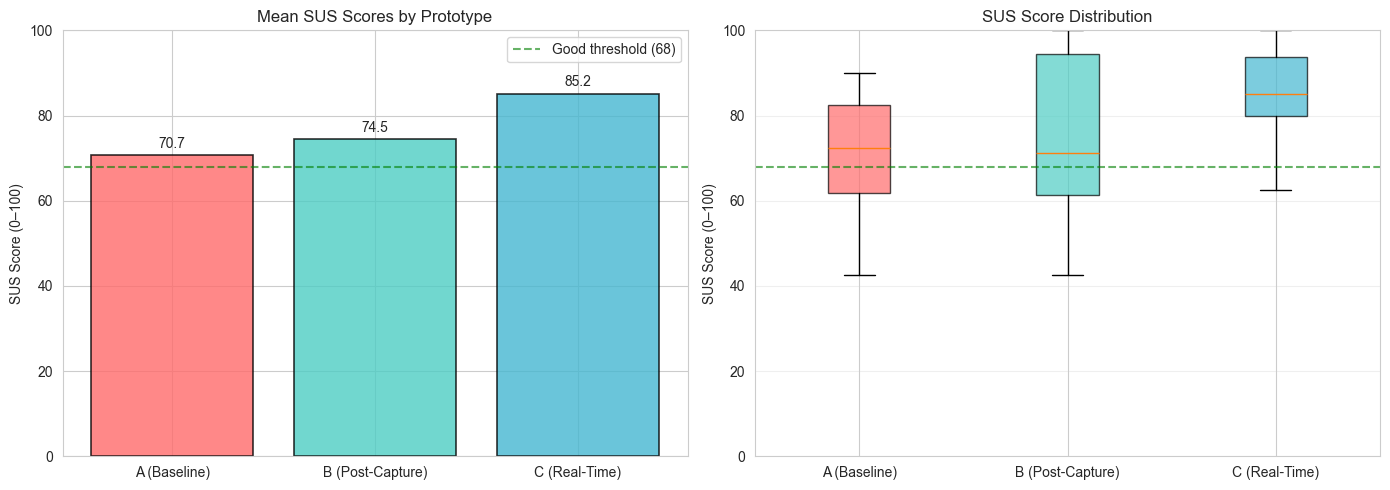

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

protos = ['A (Baseline)', 'B (Post-Capture)', 'C (Real-Time)']
means = [
    df_filtered['sus_score_A'].mean(),
    df_filtered['sus_score_B'].mean(),
    df_filtered['sus_score_C'].mean()
]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax1.bar(protos, means, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax1.axhline(y=68, color='green', linestyle='--', linewidth=1.5, alpha=0.6, label='Good threshold (68)')
ax1.set_ylabel('SUS Score (0–100)')
ax1.set_title('Mean SUS Scores by Prototype')
ax1.set_ylim([0, 100])
ax1.legend()
for bar in bars:
    h = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., h + 1, f'{h:0.1f}', ha='center', va='bottom', fontsize=10)

# Box plot
sus_data = [
    df_filtered['sus_score_A'].dropna(),
    df_filtered['sus_score_B'].dropna(),
    df_filtered['sus_score_C'].dropna()
]
bp = ax2.boxplot(sus_data, labels=protos, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.axhline(y=68, color='green', linestyle='--', linewidth=1.5, alpha=0.6)
ax2.set_ylabel('SUS Score (0–100)')
ax2.set_title('SUS Score Distribution')
ax2.set_ylim([0, 100])
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Participant Counts (Filtered Set)
Quick checks of who was included after filtering.

In [6]:
print('Participants included (usernames):')
included_usernames = df_filtered['username_clean'].dropna().unique().tolist()
print(sorted(included_usernames))
print(f'Total included: {len(included_usernames)}')

Participants included (usernames):
['andy', 'ante', 'boyan', 'bran', 'césar van leuffelen', 'daafit', 'jelle venema', 'julia', 'matteo', 'menno sman', 'saviras', 'schnurito', 'valentino', 'vdhoogen']
Total included: 14


## Statistical Analysis: Checking Assumptions & Choosing the Right Test

To select the most appropriate statistical test, we first assess whether the data meets the assumptions required by parametric tests (like paired t-tests) or if we should use non-parametric alternatives (like Wilcoxon signed-rank tests).

**Tests to evaluate:**
- **Paired t-test** (parametric): Assumes differences are normally distributed. More powerful if assumption holds.
- **Wilcoxon signed-rank test** (non-parametric): No normality assumption. Robust and recommended for small samples or non-normal data.

Participants with complete SUS data (all three prototypes): 14

ASSUMPTION CHECK: Normality of Pairwise Differences

Shapiro-Wilk Normality Test (H₀: data is normally distributed)
----------------------------------------------------------------------
A vs B difference: W = 0.9646, p = 0.7975
  → NORMAL (p > 0.05): Differences appear normally distributed

A vs C difference: W = 0.8184, p = 0.0085
  → NOT NORMAL (p ≤ 0.05): Differences deviate from normal distribution


Visual Inspection of Distributions


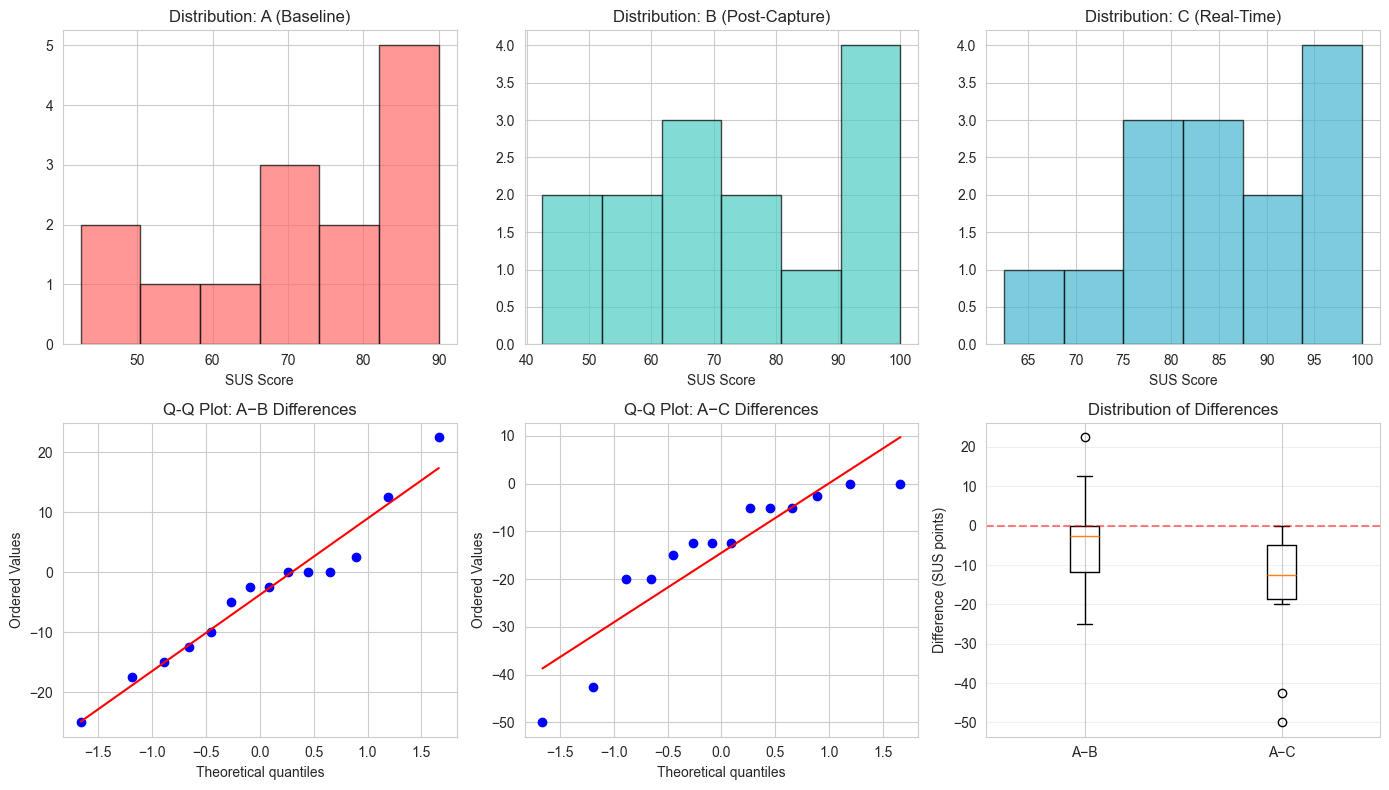



TEST SELECTION

◐ RECOMMENDATION: WILCOXON SIGNED-RANK TEST
  One comparison shows non-normal differences.
  Non-parametric test is safer for robustness.

  Sample size: n = 14 (small sample → non-parametric preferred)



In [7]:
from scipy.stats import shapiro, wilcoxon, ttest_rel
from scipy import stats

# Prepare complete cases (all three SUS scores present)
df_complete = df_filtered[['sus_score_A', 'sus_score_B', 'sus_score_C']].dropna()

print(f'Participants with complete SUS data (all three prototypes): {len(df_complete)}')
print()

# ============================================================================
# CHECK ASSUMPTIONS: Normality of Differences
# ============================================================================
print('ASSUMPTION CHECK: Normality of Pairwise Differences')
print('=' * 70)
print()

# Calculate differences
diff_ab = df_complete['sus_score_A'] - df_complete['sus_score_B']
diff_ac = df_complete['sus_score_A'] - df_complete['sus_score_C']

# Shapiro-Wilk test for normality
stat_ab, p_ab = shapiro(diff_ab)
stat_ac, p_ac = shapiro(diff_ac)

print('Shapiro-Wilk Normality Test (H₀: data is normally distributed)')
print('-' * 70)
print(f'A vs B difference: W = {stat_ab:.4f}, p = {p_ab:.4f}')
if p_ab > 0.05:
    print('  → NORMAL (p > 0.05): Differences appear normally distributed')
    norm_ab = True
else:
    print('  → NOT NORMAL (p ≤ 0.05): Differences deviate from normal distribution')
    norm_ab = False

print()
print(f'A vs C difference: W = {stat_ac:.4f}, p = {p_ac:.4f}')
if p_ac > 0.05:
    print('  → NORMAL (p > 0.05): Differences appear normally distributed')
    norm_ac = True
else:
    print('  → NOT NORMAL (p ≤ 0.05): Differences deviate from normal distribution')
    norm_ac = False

print()
print()

# ============================================================================
# VISUALIZE DISTRIBUTIONS
# ============================================================================
print('Visual Inspection of Distributions')
print('=' * 70)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Row 1: Individual score distributions
axes[0, 0].hist(df_complete['sus_score_A'], bins=6, alpha=0.7, color='#FF6B6B', edgecolor='black')
axes[0, 0].set_title('Distribution: A (Baseline)')
axes[0, 0].set_xlabel('SUS Score')

axes[0, 1].hist(df_complete['sus_score_B'], bins=6, alpha=0.7, color='#4ECDC4', edgecolor='black')
axes[0, 1].set_title('Distribution: B (Post-Capture)')
axes[0, 1].set_xlabel('SUS Score')

axes[0, 2].hist(df_complete['sus_score_C'], bins=6, alpha=0.7, color='#45B7D1', edgecolor='black')
axes[0, 2].set_title('Distribution: C (Real-Time)')
axes[0, 2].set_xlabel('SUS Score')

# Row 2: Q-Q plots for differences
from scipy import stats as sp_stats
sp_stats.probplot(diff_ab, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: A−B Differences')

sp_stats.probplot(diff_ac, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: A−C Differences')

axes[1, 2].boxplot([diff_ab, diff_ac], labels=['A−B', 'A−C'])
axes[1, 2].set_title('Distribution of Differences')
axes[1, 2].set_ylabel('Difference (SUS points)')
axes[1, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print()
print()

# ============================================================================
# DECISION: CHOOSE TEST BASED ON ASSUMPTIONS
# ============================================================================
print('TEST SELECTION')
print('=' * 70)
print()

both_normal = norm_ab and norm_ac
at_least_one_normal = norm_ab or norm_ac

if both_normal:
    chosen_test = 'paired_ttest'
    print('✓ RECOMMENDATION: PAIRED T-TEST')
    print('  Both differences are normally distributed (p > 0.05).')
    print('  Parametric test is appropriate and more powerful.')
elif at_least_one_normal:
    chosen_test = 'wilcoxon'
    print('◐ RECOMMENDATION: WILCOXON SIGNED-RANK TEST')
    print('  One comparison shows non-normal differences.')
    print('  Non-parametric test is safer for robustness.')
else:
    chosen_test = 'wilcoxon'
    print('✗ RECOMMENDATION: WILCOXON SIGNED-RANK TEST')
    print('  Both comparisons show non-normal differences (p ≤ 0.05).')
    print('  Non-parametric test is necessary and more robust.')

print()
print('  Sample size: n =', len(df_complete), '(small sample → non-parametric preferred)')
print()
print('=' * 70)

In [8]:
# ============================================================================
# EXECUTE CHOSEN TEST: Pairwise Comparisons (A vs B, A vs C)
# ============================================================================
print('PAIRWISE COMPARISONS: Testing A against B and C')
print('=' * 70)
print()

if chosen_test == 'paired_ttest':
    print('Method: PAIRED T-TESTS')
    print('=' * 70)
    print('H₀: Mean SUS scores are equal | Hₐ: Mean SUS scores differ (two-tailed)')
    print()
    
    comparisons = [
        ('A (Baseline)', 'B (Post-Capture)', 'sus_score_A', 'sus_score_B'),
        ('A (Baseline)', 'C (Real-Time)', 'sus_score_A', 'sus_score_C')
    ]
    
    bonferroni_alpha = 0.05 / len(comparisons)
    print(f'Bonferroni-corrected α: {bonferroni_alpha:.4f} per test (2 tests)\n')
    
    for proto1_label, proto2_label, col1, col2 in comparisons:
        t_stat, p_t = ttest_rel(df_complete[col1], df_complete[col2])
        mean_diff = df_complete[col1].mean() - df_complete[col2].mean()
        
        # Cohen's d effect size
        diff_vals = df_complete[col1] - df_complete[col2]
        cohens_d = mean_diff / diff_vals.std()
        
        print(f'{proto1_label} vs {proto2_label}:')
        print(f'  t = {t_stat:+.4f}, p = {p_t:.4f}')
        print(f'  Mean difference: {mean_diff:+.2f} points')
        print(f"  Cohen's d: {cohens_d:+.3f}", end='')
        
        if abs(cohens_d) < 0.2:
            print(' (negligible effect)')
        elif abs(cohens_d) < 0.5:
            print(' (small effect)')
        elif abs(cohens_d) < 0.8:
            print(' (medium effect)')
        else:
            print(' (large effect)')
        
        if p_t < bonferroni_alpha:
            winner = proto1_label if mean_diff > 0 else proto2_label
            print(f'  ✓ SIGNIFICANT (p < {bonferroni_alpha:.4f})')
        else:
            print(f'  ✗ NOT significant (p ≥ {bonferroni_alpha:.4f})')
        print()

else:  # chosen_test == 'wilcoxon'
    print('Method: WILCOXON SIGNED-RANK TESTS')
    print('=' * 70)
    print('H₀: Distributions are equal | Hₐ: Distributions differ (two-tailed)')
    print()
    
    comparisons = [
        ('A (Baseline)', 'B (Post-Capture)', 'sus_score_A', 'sus_score_B'),
        ('A (Baseline)', 'C (Real-Time)', 'sus_score_A', 'sus_score_C')
    ]
    
    bonferroni_alpha = 0.05 / len(comparisons)
    print(f'Bonferroni-corrected α: {bonferroni_alpha:.4f} per test (2 tests)\n')
    
    for proto1_label, proto2_label, col1, col2 in comparisons:
        stat, p = wilcoxon(df_complete[col1], df_complete[col2])
        mean_diff = df_complete[col1].mean() - df_complete[col2].mean()
        median_diff = df_complete[col1].median() - df_complete[col2].median()
        
        # Rank-biserial correlation (effect size)
        n = len(df_complete)
        r_rb = 1 - (2 * stat) / (n * (n + 1))
        
        print(f'{proto1_label} vs {proto2_label}:')
        print(f'  W = {stat:.1f}, p = {p:.4f}')
        print(f'  Mean difference: {mean_diff:+.2f} points')
        print(f'  Median difference: {median_diff:+.2f} points')
        print(f'  Rank-biserial r: {r_rb:+.3f}', end='')
        
        if abs(r_rb) < 0.3:
            print(' (small effect)')
        elif abs(r_rb) < 0.5:
            print(' (medium effect)')
        else:
            print(' (large effect)')
        
        if p < bonferroni_alpha:
            winner = proto1_label if mean_diff > 0 else proto2_label
            print(f'  ✓ SIGNIFICANT (p < {bonferroni_alpha:.4f})')
        else:
            print(f'  ✗ NOT significant (p ≥ {bonferroni_alpha:.4f})')
        print()

print('=' * 70)

PAIRWISE COMPARISONS: Testing A against B and C

Method: WILCOXON SIGNED-RANK TESTS
H₀: Distributions are equal | Hₐ: Distributions differ (two-tailed)

Bonferroni-corrected α: 0.0250 per test (2 tests)

A (Baseline) vs B (Post-Capture):
  W = 18.5, p = 0.1962
  Mean difference: -3.75 points
  Median difference: +1.25 points
  Rank-biserial r: +0.824 (large effect)
  ✗ NOT significant (p ≥ 0.0250)

A (Baseline) vs C (Real-Time):
  W = 0.0, p = 0.0021
  Mean difference: -14.46 points
  Median difference: -12.50 points
  Rank-biserial r: +1.000 (large effect)
  ✓ SIGNIFICANT (p < 0.0250)



## Summary & Interpretation

Based on assumption testing, we use a single, most-appropriate statistical method to answer whether prototype A (Baseline) has significantly lower SUS scores than B (Post-Capture) and C (Real-Time).

In [9]:
# ============================================================================
# INTERPRETATION: Do results support the hypothesis?
# ============================================================================
print('HYPOTHESIS EVALUATION')
print('=' * 70)
print('Question: Is baseline (A) significantly lower in usability than B and C?')
print()

# Get results from the appropriate test
if chosen_test == 'paired_ttest':
    ab_stat, ab_p = ttest_rel(df_complete['sus_score_A'], df_complete['sus_score_B'])
    ac_stat, ac_p = ttest_rel(df_complete['sus_score_A'], df_complete['sus_score_C'])
else:
    ab_stat, ab_p = wilcoxon(df_complete['sus_score_A'], df_complete['sus_score_B'])
    ac_stat, ac_p = wilcoxon(df_complete['sus_score_A'], df_complete['sus_score_C'])

bonferroni_alpha = 0.05 / 2

ab_mean = df_complete['sus_score_A'].mean() - df_complete['sus_score_B'].mean()
ac_mean = df_complete['sus_score_A'].mean() - df_complete['sus_score_C'].mean()

ab_sig = ab_p < bonferroni_alpha and ab_mean < 0
ac_sig = ac_p < bonferroni_alpha and ac_mean < 0

print(f'A vs B: p = {ab_p:.4f}, diff = {ab_mean:+.2f} → {"SIGNIFICANT & lower" if ab_sig else "NOT significant or higher"}')
print(f'A vs C: p = {ac_p:.4f}, diff = {ac_mean:+.2f} → {"SIGNIFICANT & lower" if ac_sig else "NOT significant or higher"}')
print()

if ab_sig and ac_sig:
    print('✓ HYPOTHESIS SUPPORTED')
    print('  Baseline (A) is significantly lower than both B and C.')
    print('  The additional features in B and C improve usability.')
elif ab_sig or ac_sig:
    print('◐ PARTIAL SUPPORT')
    print('  Baseline (A) is significantly lower than at least one alternative.')
elif ab_mean < 0 and ac_mean < 0:
    print('◐ TREND OBSERVED (not significant)')
    print('  Mean scores show A < B and A < C, but differences are not statistically significant.')
else:
    print('✗ HYPOTHESIS NOT SUPPORTED')
    print('  No evidence that baseline (A) is lower than B and/or C.')

print()
print('=' * 70)

HYPOTHESIS EVALUATION
Question: Is baseline (A) significantly lower in usability than B and C?

A vs B: p = 0.1962, diff = -3.75 → NOT significant or higher
A vs C: p = 0.0021, diff = -14.46 → SIGNIFICANT & lower

◐ PARTIAL SUPPORT
  Baseline (A) is significantly lower than at least one alternative.



## Test Selection & Interpretation Guide

**Why we choose between parametric (t-test) and non-parametric (Wilcoxon) tests:**

- **Shapiro-Wilk test** checks if differences are normally distributed (p > 0.05 → normal)
- **Parametric paired t-test**: More powerful if normality assumption holds; assumes differences follow a normal distribution
- **Non-parametric Wilcoxon signed-rank test**: Makes no normality assumption; more robust for small samples or skewed data

**Decision rule:**
- If **both pairs** are normally distributed (p > 0.05) → Use paired t-tests (more powerful)
- If **one or both pairs** are non-normal (p ≤ 0.05) → Use Wilcoxon test (safer, more robust)

**Effect Size Interpretation:**
- **Cohen's d** (from t-tests): negligible < 0.2, small 0.2–0.5, medium 0.5–0.8, large > 0.8
- **Rank-biserial r** (from Wilcoxon): small < 0.3, medium 0.3–0.5, large > 0.5

**Significance:**
- **p < 0.025** (with Bonferroni correction for 2 tests) = statistically significant
- **p ≥ 0.025** = not statistically significant at this threshold

# LaTeX Output for Paper

Generate publication-ready figures for the usability results section.

Saved boxplot figure to: sus_boxplots_by_prototype.png and .pdf


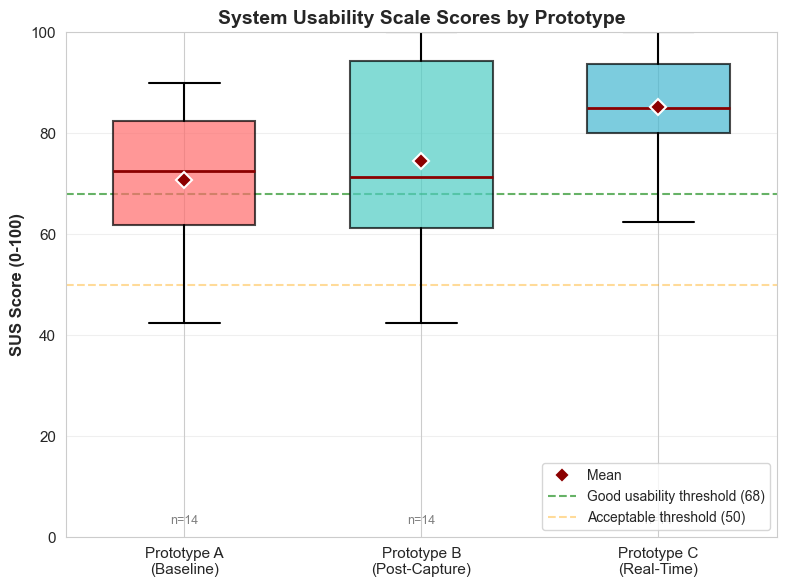


LaTeX Figure Code (Boxplots):
\begin{figure}[htbp]
\centering
\includegraphics[width=0.7\textwidth]{sus_boxplots_by_prototype.pdf}
\caption{Distribution of System Usability Scale (SUS) scores across three prototypes. Boxplots show median (red center line), interquartile range (box), and outliers (whiskers). Red diamonds indicate mean values. Dashed lines represent SUS benchmarks: 68 (good usability) and 50 (acceptable usability). Sample sizes are shown below each box.}
\label{fig:sus_boxplots}
\end{figure}

Saved LaTeX figure code to: latex_sus_boxplots.tex


In [10]:
# Figure 1: Boxplots of SUS scores per prototype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Prepare data
sus_data = [
    df_complete['sus_score_A'].dropna(),
    df_complete['sus_score_B'].dropna(),
    df_complete['sus_score_C'].dropna()
]
labels = ['Prototype A\n(Baseline)', 'Prototype B\n(Post-Capture)', 'Prototype C\n(Real-Time)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Create boxplot
bp = ax.boxplot(sus_data, labels=labels, patch_artist=True, widths=0.6)

# Color boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_linewidth(1.5)

# Style whiskers, caps, medians
for whisker in bp['whiskers']:
    whisker.set_linewidth(1.5)
for cap in bp['caps']:
    cap.set_linewidth(1.5)
for median in bp['medians']:
    median.set_color('darkred')
    median.set_linewidth(2)

# Add mean markers
means = [data.mean() for data in sus_data]
ax.plot(range(1, 4), means, 'D', color='darkred', markersize=8, 
        label='Mean', zorder=5, markeredgecolor='white', markeredgewidth=1.5)

# Add SUS threshold lines
ax.axhline(y=68, color='green', linestyle='--', linewidth=1.5, alpha=0.6, 
          label='Good usability threshold (68)', zorder=1)
ax.axhline(y=50, color='orange', linestyle='--', linewidth=1.5, alpha=0.4, 
          label='Acceptable threshold (50)', zorder=1)

ax.set_ylabel('SUS Score (0-100)', fontsize=12, fontweight='bold')
ax.set_title('System Usability Scale Scores by Prototype', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='lower right', fontsize=10)

# Add sample sizes
for i, data in enumerate(sus_data):
    n = len(data)
    ax.text(i + 1, 2, f'n={n}', ha='center', va='bottom', fontsize=9, color='gray')

plt.tight_layout()

# Save figure
plt.savefig('sus_boxplots_by_prototype.png', dpi=300, bbox_inches='tight')
plt.savefig('sus_boxplots_by_prototype.pdf', bbox_inches='tight')
print("Saved boxplot figure to: sus_boxplots_by_prototype.png and .pdf")

plt.show()

# Generate LaTeX figure code
latex_figure_boxplot = r"""\begin{figure}[htbp]
\centering
\includegraphics[width=0.7\textwidth]{sus_boxplots_by_prototype.pdf}
\caption{Distribution of System Usability Scale (SUS) scores across three prototypes. Boxplots show median (red center line), interquartile range (box), and outliers (whiskers). Red diamonds indicate mean values. Dashed lines represent SUS benchmarks: 68 (good usability) and 50 (acceptable usability). Sample sizes are shown below each box.}
\label{fig:sus_boxplots}
\end{figure}"""

print("\n" + "="*80)
print("LaTeX Figure Code (Boxplots):")
print(latex_figure_boxplot)
print("="*80 + "\n")

# Save LaTeX code to file
with open("latex_sus_boxplots.tex", "w") as f:
    f.write(latex_figure_boxplot)
print("Saved LaTeX figure code to: latex_sus_boxplots.tex")

Saved paired-line plot to: sus_paired_lines_by_prototype.png and .pdf


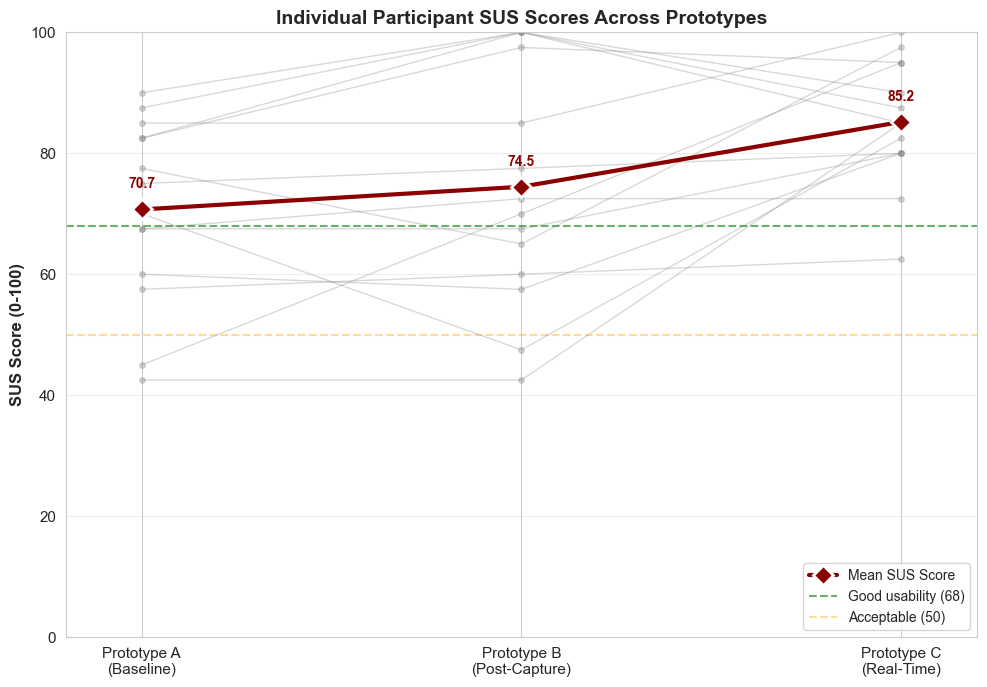


LaTeX Figure Code (Paired-Line Plot):
\begin{figure}[htbp]
\centering
\includegraphics[width=0.8\textwidth]{sus_paired_lines_by_prototype.pdf}
\caption{Individual participant SUS score trajectories across prototypes. Each gray line represents one participant's scores for all three prototypes, showing within-subject changes in perceived usability. The bold red line indicates the mean SUS score across all participants. Dashed lines represent usability benchmarks (68 = good, 50 = acceptable). This visualization reveals individual variation and overall trends in usability perception.}
\label{fig:sus_paired_lines}
\end{figure}

Saved LaTeX figure code to: latex_sus_paired_lines.tex


In [11]:
# Figure 2: Paired-line plots of individual participant SUS scores
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Prepare data - one line per participant connecting their three scores
n_participants = len(df_complete)
x_positions = [1, 2, 3]  # A, B, C
labels = ['Prototype A\n(Baseline)', 'Prototype B\n(Post-Capture)', 'Prototype C\n(Real-Time)']

# Plot individual participant lines
for idx, row in df_complete.iterrows():
    scores = [row['sus_score_A'], row['sus_score_B'], row['sus_score_C']]
    ax.plot(x_positions, scores, 'o-', color='gray', alpha=0.3, linewidth=1, markersize=4)

# Overlay mean line with emphasis
mean_scores = [
    df_complete['sus_score_A'].mean(),
    df_complete['sus_score_B'].mean(),
    df_complete['sus_score_C'].mean()
]
ax.plot(x_positions, mean_scores, 'D-', color='darkred', linewidth=3, markersize=10,
        label='Mean SUS Score', zorder=10, markeredgecolor='white', markeredgewidth=2)

# Add SUS threshold lines
ax.axhline(y=68, color='green', linestyle='--', linewidth=1.5, alpha=0.6, 
          label='Good usability (68)', zorder=1)
ax.axhline(y=50, color='orange', linestyle='--', linewidth=1.5, alpha=0.4, 
          label='Acceptable (50)', zorder=1)

# Formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('SUS Score (0-100)', fontsize=12, fontweight='bold')
ax.set_title('Individual Participant SUS Scores Across Prototypes', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.set_xlim([0.8, 3.2])
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='lower right', fontsize=10)

# Add mean value labels
for i, (x, y) in enumerate(zip(x_positions, mean_scores)):
    ax.text(x, y + 3, f'{y:.1f}', ha='center', va='bottom', 
           fontsize=10, fontweight='bold', color='darkred')

plt.tight_layout()

# Save figure
plt.savefig('sus_paired_lines_by_prototype.png', dpi=300, bbox_inches='tight')
plt.savefig('sus_paired_lines_by_prototype.pdf', bbox_inches='tight')
print("Saved paired-line plot to: sus_paired_lines_by_prototype.png and .pdf")

plt.show()

# Generate LaTeX figure code
latex_figure_lines = r"""\begin{figure}[htbp]
\centering
\includegraphics[width=0.8\textwidth]{sus_paired_lines_by_prototype.pdf}
\caption{Individual participant SUS score trajectories across prototypes. Each gray line represents one participant's scores for all three prototypes, showing within-subject changes in perceived usability. The bold red line indicates the mean SUS score across all participants. Dashed lines represent usability benchmarks (68 = good, 50 = acceptable). This visualization reveals individual variation and overall trends in usability perception.}
\label{fig:sus_paired_lines}
\end{figure}"""

print("\n" + "="*80)
print("LaTeX Figure Code (Paired-Line Plot):")
print(latex_figure_lines)
print("="*80 + "\n")

# Save LaTeX code to file
with open("latex_sus_paired_lines.tex", "w") as f:
    f.write(latex_figure_lines)
print("Saved LaTeX figure code to: latex_sus_paired_lines.tex")

## Instructions for LaTeX

The above cells generate:

1. **SUS Boxplots Figure** (`sus_boxplots_by_prototype.pdf` and `latex_sus_boxplots.tex`): Shows the distribution of SUS scores for each prototype with boxplots. Includes mean markers (red diamonds), medians (red center lines), and SUS benchmark thresholds (68 for "good", 50 for "acceptable"). Sample sizes are displayed below each box.

2. **Paired-Line Plot Figure** (`sus_paired_lines_by_prototype.pdf` and `latex_sus_paired_lines.tex`): Shows individual participant trajectories across the three prototypes. Each gray line connects one participant's scores for A, B, and C, revealing within-subject changes. The bold red line shows the overall mean trend across participants. This visualization is particularly powerful for demonstrating how individual users' perceptions changed across prototypes.

**Required LaTeX packages:**
```latex
\usepackage{graphicx}  % for \includegraphics
```

**To use in your paper:**
- Copy the `.pdf` files to your LaTeX project directory
- Use `\input{latex_sus_boxplots.tex}` or `\input{latex_sus_paired_lines.tex}` to include the figures
- Or copy the LaTeX code directly into your document
- Reference the figures in text with `\ref{fig:sus_boxplots}` and `\ref{fig:sus_paired_lines}`

**Note:** Make sure you've executed all previous cells in this notebook to compute `df_complete` (the DataFrame with participants who have complete SUS data for all three prototypes) before running these visualization cells.